# Final Project: The Mathematical Engineering of Deep Learning
## Rohan Hitchcock

Course website: [deeplearningmath.org](https://deeplearningmath.org)

This demonstration explores results in the paper "Wasserstein GAN" by M. Arjovsky, S. Chintala, and L. Bottou (2017) [arXiv: 1701.07875 [stat.ML]](https://arxiv.org/abs/1701.07875).

In [ ]:
import torch
import torchvision
from torch import nn
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as cmap

# Approximating Wasserstein Distance

Let $\mathbf{P}_a$ and $\mathbf{P}_b$ be probability distributions. It was shown in the paper that we can approximate the Wasserstein distance $W(\mathbf{P}_a, \mathbf{P}_b)$ between $\mathbf{P}_a$ and $\mathbf{P}_b$ up to an unknown positive constant $\kappa \in \mathbb{R}$ as
\begin{equation}
\kappa \cdot W(\mathbf{P}_a, \mathbf{P}_b) = \max _{w \in \mathcal{W}} \left( \mathbb{E} _{x \sim \mathbf{P}_a} \left[f_w(x)\right] - \mathbb{E} _{z \sim \mathbf{P}_b} \left[f_w(z)\right] \right) \quad (\text{1})
\end{equation}
where $\mathcal{W}$ is a compact space and $\{ f_w \}_{w \in \mathcal{W}}$ are neural networks with weights $w \in \mathcal{W}$.

We now proceed as we would with any optimization problem involving a neural 
network. Since $\mathcal{W}$ must be compact we take $\mathcal{W} = [-c, c]^p$ for some $c > 0$ (a hyperparameter), and after each update from our optimizer we apply the function $clip_c$ to each parameter of the network, where
$$ clip_c(w) = \begin{cases} c & w > c\\ -c & w < -c \\ w & \text{otherwise} \end{cases} .$$ 

In [ ]:
def clip(m, c):
    """ Applies clip_c to each parameter within a neural network module m.
        Operates in-place. 

        Args:
            m: An object of type nn.Module
            c: The clipping parameter, a positive numeber.
    """
    with torch.no_grad():
        try:
            # update occurs in-place
            m.weight.clip_(-c, c)
            m.bias.clip_(-c, c)
        except AttributeError:
            # m is a module with no parameters
            pass

In this case we select RMSProp as our optimizer, since the authors of the paper recommend using an optimization algorithm which does not use momentum. In each iteration of the algorithm we sample $m$ values $\{x_i\}_{i=1} ^m$ and $\{z_i\}_{i=1} ^m$ from $\mathbf{P}_a$ and $\mathbf{P}_b$ respectively and compute
\begin{equation}
V = \frac{1}{m}\sum _{i=1} ^m f_w(x_i) - \frac{1}{m}\sum _{i=1} ^m f_w(z_i)
\end{equation}
where $f_w$ is our neural network. Since pytorch optimizers minimize functions we take $L = -V$. In the usual way we compute $\nabla _w L$ using the backpropagation implementation in pytorch and update the weights using the RMSProp algorithm. To enforce the compactness condition on the weight space $\mathcal{W}$, after each iteration we apply `clip(m, c)` to every module in the network.

In [ ]:
def wasserstein_discriminator(dist1, dist2, discr, batch_size=100, num_iter=500, c=0.5, lr=0.001):
    """ This function trains a neural network discr which maximizes equation
        (1) for distributions dist1 and dist2.

        Args:
            dist1, dist2: probability distributions. Must implement a method 
            called `sample(m)` which returns m samples from the distribution as 
            a pytorch tensor.
            discr: A neural network, an instance of nn.Module
            batch_size: the number of samples to use in each iteration
            num_iter: the number of iterations to optimize for
            c: the clipping paramerer (positive)
            lr: the learning rate for RMSProp

        Returns:
            An optimized version of discr
    """

    clipper = lambda x : clip(x, c)

    discr.apply(clipper)

    optimizer = torch.optim.RMSprop(discr.parameters(), lr=lr)

    for _ in range(num_iter):
        
        sample1 = dist1.sample(batch_size)
        sample2 = dist2.sample(batch_size)

        optimizer.zero_grad()

        wass_loss = -(discr(sample1).mean() - discr(sample2).mean())
    
        wass_loss.backward()

        optimizer.step()
        discr.apply(clipper)
        
    return discr

def wasserstein_distance(dist1, dist2, optimal_discr, sample_size=1000):
    """ Given an optimized function (see (1)) computes the Wasserstein distance
        between dist1 and dist2 up to an unknow positive scalar multiple.

        Args:
            dist1, dist2: probability distributions, as in wasserstein_discriminator
            optimal_discr: the optimal f_w from equation (1), for example the return
            value of wasserstein_discriminator
            sample_size: the number of samples used to estimate the expectations
            in (1)

        Returns:
            An estimate of the wasserstein distance between dist1 and dist2 up
            to a positive constant multiple.
    """

    a = optimal_discr(dist1.sample(sample_size)).mean()
    b = optimal_discr(dist2.sample(sample_size)).mean()

    return (a - b).detach().numpy()

We now apply our approximation of the Wasserstein distance to Example 1 of the paper. In this example we consider a family of random variables $(\theta, Z) \in \mathbb{R}^2$ parameterised by $\theta \in \mathbb{R}$,  where $Z \sim U[0, 1]$ is uniform. We consider $\theta = 0$ to be the 'true' parameter, and plot the Wasserstein distance $W(\mathbf{P}_\theta, \mathbf{P}_0)$, where $(\theta, Z) \sim \mathbf{P}_\theta$, as a function of $\theta$. It can be shown that $W(\mathbf{P}_\theta, \mathbf{P}_0) = |\theta|$, so when we apply our approximation algorithm to this situation we expect to see a plot which looks like the graph of $h(\theta) = \kappa \cdot |\theta|$, for $\kappa > 0$.

In the following code we introduce the class `TestRV`, which implements the random variables $(\theta, Z)$ with the interface expected by wasserstein_distance.

In [ ]:
class TestRV:

    def __init__(self, theta):
        self.theta = theta

    def sample(self, n):
        return torch.from_numpy(np.vstack((self.theta * np.ones(n), stats.uniform.rvs(size=n))).T).to(torch.float)

    @staticmethod
    def dim():
        return 2

We now use our algorithm to compute $\kappa \cdot W(\mathbf{P}_\theta, \mathbf{P}_0)$ for several values of $\theta$. We use a neural network with a one hidden layer of size 10 with sigmoid activation functions. For the output we take a linear combination of the 10 neurons in the hidden layer (no activation function). 

In [ ]:
class PlottingDiscriminator(nn.Module):

    def __init__(self, input_size, clipping):
        super(PlottingDiscriminator, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(input_size, 10), nn.Sigmoid())
        self.layer2 = nn.Linear(10, 1)

        rv = torch.distributions.Normal(0, 0.1 * clipping)
        for m in self.modules():
            if type(m) == nn.Linear:
                m.weight = nn.Parameter(rv.sample(m.weight.shape))
                m.bias = nn.Parameter(torch.zeros(m.bias.shape))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out

The cell below takes 15-20s to run.

Computing (1/21) distances ... Done!
Computing (2/21) distances ... Done!
Computing (3/21) distances ... Done!
Computing (4/21) distances ... Done!
Computing (5/21) distances ... Done!
Computing (6/21) distances ... Done!
Computing (7/21) distances ... Done!
Computing (8/21) distances ... Done!
Computing (9/21) distances ... Done!
Computing (10/21) distances ... Done!
Computing (11/21) distances ... Done!
Computing (12/21) distances ... Done!
Computing (13/21) distances ... Done!
Computing (14/21) distances ... Done!
Computing (15/21) distances ... Done!
Computing (16/21) distances ... Done!
Computing (17/21) distances ... Done!
Computing (18/21) distances ... Done!
Computing (19/21) distances ... Done!
Computing (20/21) distances ... Done!
Computing (21/21) distances ... Done!


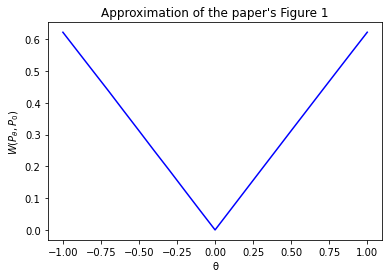

In [ ]:
num_vals = 21
true_theta = 0
clipping = 0.5

thetas = np.linspace(-1, 1, num=num_vals)
distance_w = np.empty(num_vals)

true_dist = TestRV(true_theta)

for i, theta in enumerate(thetas):

    print(f"Computing ({i+1}/{num_vals}) distances ... ", end="", flush=True)

    test_dist = TestRV(theta)
    discriminator = PlottingDiscriminator(TestRV.dim(), clipping)
    optimal_discriminator = wasserstein_discriminator(true_dist, test_dist, discriminator)
    distance_w[i] = wasserstein_distance(true_dist, test_dist, optimal_discriminator)

    print("Done!")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(thetas, distance_w, color='b')
ax.set_xlabel("θ")
ax.set_ylabel("$W(P_θ, P_0)$")
ax.set_title("Approximation of the paper's Figure 1")

plt.show()

# Implementing the WGAN Algorithm

We now implement the WGAN algorithm proposed in the paper (Algorithm 1). In the code below the inner loop (labelled loop2) is the same as in the plotting algorithm above. For a fixed generator function $g_\theta$ it estimates the Wasserstein distance (up to a scalar multiple) between the real data distributuion $\mathbf{P}_r$ and $g_\theta(Z) \sim \mathbf{P}_\theta$ (where $Z \sim \mathbf{P}_{\text{noise}}$ is some fixed noise distribution) using a neural network $f_w$ which we call the discriminator. After this loop, we compute the gradient of the Wassserstein distance with respect to the parameters of the the generator $g_\theta$, and so adjust those parameters so that the Wasserstein distance between $\mathbf{P}_r$ and $\mathbf{P_\theta}$ is reduced. 

In summary we attempt to find a discriminator $f_w$ which computes
$$\kappa \cdot W(\mathbf P_r, \mathbf P_\theta) \approx \max _{w \in W} \left(\mathbb{E}_{x \sim \mathbf P_r} \left[f_w(x)\right] - 
\mathbb E _{z\sim \mathbf P_{\text{noise}}} \left[f_w(g_\theta(z))\right]\right) $$
for each value of $\theta$, and a generator $g_\theta$ which minimizes this:
$$
    \min _{\theta \in \Theta} \kappa \cdot W(\mathbf P_r, \mathbf P _\theta) \approx \min _{\theta \in \Theta}\max _{w \in W} \left(\mathbb{E}_{x \sim \mathbf P_r} \left[f_w(x)\right] - 
\mathbb E _{z\sim \mathbf P_{\text{noise}}} \left[f_w(g_\theta(z))\right]\right) \approx W(\mathbf P_r, \mathbf P_\theta) $$

In [ ]:
def wgan(generator, discriminator, data, noise, c, n_discr=50, n_iter=100, batch_size=100):
    """ Implements the WGAN algorithm for training generative adversarial 
        networks.

        Args:
            generator: a neural network to use as the generator g_\theta, type nn.Module
            discriminator: a neural network to use as the discriminator f_w, type nn.Module
            data: an object which allows access to real data samples using the 
            interface data.get_batch(m), which returns m real data samples as a tensor
            noise: a probability distribution, eg from torch.distributions
            c: the clipping parameter, positive
            n_discr: the number of iterations to train the discriminator
            n_iter: the number of iterations to train the generator.
            batch_size: the number of samples to use each gradient update
        
        Returns:
            An optimized generator and discriminator
    """
    #use the same clipping function as the previous section
    clipper = lambda m : clip(m, c)

    discriminator.apply(clipper)

    d_optimizer = torch.optim.RMSprop(discriminator.parameters())
    g_optimizer = torch.optim.RMSprop(generator.parameters())

    # loop1
    for i in range(n_iter):

        # loop2
        for j in range(n_discr):
            
            # we disable gradient calculation for the discriminator when the 
            # generator is being trained, so re-enable it here 
            discriminator.requires_grad_(True)

            noise_sample = noise.sample((batch_size,))
            true_sample = data.get_batch(batch_size)

            # only training discriminator here, so no need to compute these gradients
            with torch.no_grad():
                gen_sample = generator(noise_sample)

            d_optimizer.zero_grad()

            wloss = -(discriminator(true_sample).mean() - discriminator(gen_sample).mean())

            wloss.backward()
            d_optimizer.step()
            discriminator.apply(clipper)

        # Avoid unecessary gradient calculation for the discriminator, which is 
        # not being trained in this section. This method allows gradients to
        # be computed 'through' the discriminator (while torch.no_grad does not)
        discriminator.requires_grad_(False)

        noise_sample = noise.sample((batch_size,))

        g_optimizer.zero_grad()

        out = -discriminator(generator(noise_sample)).mean()

        out.backward()
        g_optimizer.step()
        
    return generator, discriminator

For comparison we also implement the standard GAN training algorithm. It is very similar, except it does not clip the weights and hence does not require a clipping parameter, and its loss function is different.

In [ ]:
def vanilla_gan(generator, discriminator, data, noise, n_discr=1, n_iter=1000, batch_size=100):

    d_optimizer = torch.optim.RMSprop(discriminator.parameters())
    g_optimizer = torch.optim.RMSprop(generator.parameters())

    for i in range(n_iter):

        for j in range(n_discr):
            
            discriminator.requires_grad_(True)

            noise_sample = noise.sample((batch_size,))
            true_sample = data.get_batch(batch_size)

            with torch.no_grad():
                gen_sample = generator(noise_sample)

            d_optimizer.zero_grad()
            
            # since we want do gradient ascent wrt to the discriminator's 
            # parameters, negate the standard loss function here
            loss = -(torch.log(discriminator(true_sample)) + torch.log(1 - discriminator(gen_sample))).mean()

            loss.backward()

            d_optimizer.step()

        discriminator.requires_grad_(False)
        
        noise_sample = noise.sample((batch_size,))

        g_optimizer.zero_grad()

        out = torch.log(1 - discriminator(generator(noise_sample))).mean()

        out.backward()
        g_optimizer.step()
        
    return generator, discriminator

We now demonstrate the WGAN algorithm and compare it to the standard GAN approach on the MNIST dataset. In order to demonstrate the robustness of the WGAN approach we aim to to use very generic arcitectures which are not tuned to the task at hand. As such we opted to use fully connected networks with two hidden layers, each of size 100 with ReLU activation functions. Batch normalization is not used. 

For the generators (these are identical in for both WGAN and standard approaches) each output neuron is a linear combination of the neurons in the previous layer (no activation function). Similarly the discriminator used in the WGAN algorithm has one output neuron which is a linear combination of the previous layer. The discriminator in the standard GAN alogithm is the same, except a sigmoid activation function is applied to the last neuron. This is because the discriminator in the standard GAN approach is assumed to be estimating the probability that a particular sample comes from the real distribution, while in the WGAN approach we are estimating a supremum over all $\kappa$-Lipschitz, not all of which would be bounded by $[0, 1]$.

In [ ]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_size=100):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(input_size, hidden_size), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.ReLU())
        self.layer3 = nn.Linear(hidden_size, 28 * 28)

        # initialization of weights and biases
        rv = torch.distributions.Normal(0, 0.1)
        for m in self.modules():
            if type(m) == nn.Linear:
                m.weight = nn.Parameter(rv.sample(m.weight.shape))
                m.bias = nn.Parameter(torch.zeros(m.bias.shape))

    def forward(self, x):
        out = x.reshape(x.shape[0], -1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.shape[0], 28, 28)
        return out


class WganDiscriminator(nn.Module):

    def __init__(self, clipping, hidden_size=100):
        super(WganDiscriminator, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(28 * 28, hidden_size), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(hidden_size, 1))

        # initialization of weights and biases
        rv = torch.distributions.Normal(0, 0.1 * clipping)
        for m in self.modules():
            if type(m) == nn.Linear:
                m.weight = nn.Parameter(rv.sample(m.weight.shape))
                m.bias = nn.Parameter(torch.zeros(m.bias.shape))

    def forward(self, x):
        out = x.reshape(x.shape[0], -1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

class VanillaDiscriminator(nn.Module):

    def __init__(self, hidden_size=100):
        super(VanillaDiscriminator, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(28 * 28, hidden_size), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(hidden_size, 1), nn.Sigmoid())

        # initialization of weights and biases
        rv = torch.distributions.Normal(0, 0.01)
        for m in self.modules():
            if type(m) == nn.Linear:
                m.weight = nn.Parameter(rv.sample(m.weight.shape))
                m.bias = nn.Parameter(torch.zeros(m.bias.shape))

    def forward(self, x):
        out = x.reshape(x.shape[0], -1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

We introduce the DataManager class to manage data batches, and a function to plot generated images.

In [ ]:
class DataManager:
    def __init__(self, tensors):
        self.data = tensors
        self.curr = 0

    def get_batch(self, size):
        if self.curr + size > len(self.data):
            self.curr = 0
        return self.data[self.curr:self.curr+size]
    
    def reset(self):
        self.curr = 0

def generate_and_plot(trained_generator, noise, grid_size=3, fig_title=""):
    """ Generates a grid_size x grid_size grid of images generated by the 
        trained_generator from the given noise distribution. """
    fig = plt.figure()
    for i in range(grid_size ** 2):

        ax = fig.add_subplot(grid_size, grid_size, i + 1)

        z = noise.sample((1,))
        im = trained_generator(z).detach().numpy().reshape(28, 28)
        ax.imshow(im, cmap=cmap.Greys)

    fig.suptitle(fig_title)
    plt.show()

def get_mnist_subset(mnist_dataset, digits):
    """ For the MNIST dataset, returns the subset of the images for which the
        true class is a digit in digits (a non-empty array of integers) """
    assert len(digits) > 0

    i = (mnist_dataset.targets == digits[0])
    for n in digits[1:]:
        i = torch.logical_or(i, mnist_dataset.targets == n)
    
    return DataManager(mnist_dataset.data[i] / 255)

In [ ]:
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)

clipping = 1
gen_in_size = 64
noise = torch.distributions.MultivariateNormal(torch.zeros(gen_in_size), torch.eye(gen_in_size))

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


We begin by only using images from a single class from MNIST.

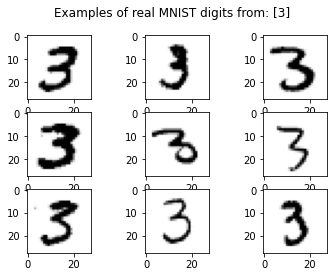

In [ ]:
digits = [3]
data = get_mnist_subset(dataset, digits)

fig = plt.figure()
for i, im in enumerate(data.get_batch(9)):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(im, cmap=cmap.Greys)

fig.suptitle(f"Examples of real MNIST digits from: {digits}")
plt.show()

A generator trained using the WGAN algorithm can produce decent examples of the chosen MNIST class. Running the algorithm for more iterations by adjusting the `n_iter` and `n_discr` parameters results in a generator which produces better, more varied samples. This significantly increases the execution time, however.

The cell below takes 25-30s to run.

In [ ]:
data.reset()
w_generator, w_discriminator = wgan(Generator(gen_in_size), WganDiscriminator(clipping), data, noise, clipping)

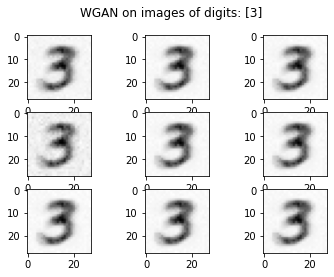

In [ ]:
generate_and_plot(w_generator, noise, fig_title=f"WGAN on images of digits: {digits}")

On the other hand using the standard GAN algorithm does not produce acceptable results. Sometimes it results in a generator which produces samples which appear no different from random noise, and sometimes the gradient blows up and numerical issues mean the generator cannot produce samples. Increasing the number of iterations does not appear to affect the results. 

The cell below takes 25-30s to run.

In [ ]:
data.reset()
v_generator, v_discriminator = vanilla_gan(Generator(gen_in_size), VanillaDiscriminator(), data, noise)

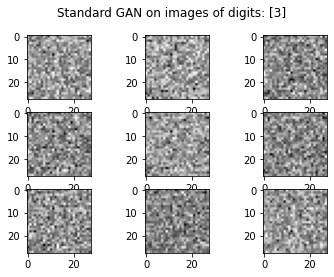

In [ ]:
generate_and_plot(v_generator, noise, fig_title=f"Standard GAN on images of digits: {digits}")

The WGAN algorithm is also capable of training a generator on samples from two MNIST classes, although this requires significantly increasing the training time. Results are not as good as using a single class and often samples from one of the two classes are produced much more frequently than other.  

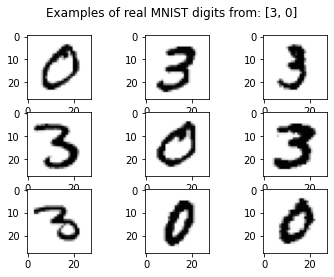

In [ ]:
digits = [3, 0]
data = get_mnist_subset(dataset, digits)

fig = plt.figure()
for i, im in enumerate(data.get_batch(9)):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(im, cmap=cmap.Greys)

fig.suptitle(f"Examples of real MNIST digits from: {digits}")
plt.show()

This cell takes 10-15min to run.

In [ ]:
data.reset()
w_generator, w_discriminator = wgan(Generator(gen_in_size), WganDiscriminator(clipping), data, noise, clipping, n_iter=1000, n_discr=100)

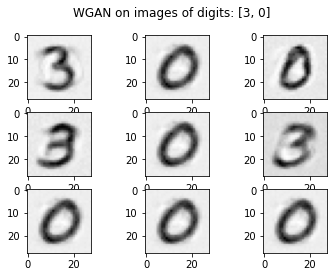

In [ ]:
generate_and_plot(w_generator, noise, fig_title=f"WGAN on images of digits: {digits}")

The point of this demonstration is not to produce the most effective generator using the WGAN algorithm, but rather to demonstrate the robustness of the WGAN algorithm. Indeed, there is no reason to expect that these network architectures are well-suited to this task of working with images. Despite this, however, the WGAN approach is able to produce decent results on a simple version of the problem with a limited computational budget. This is not the case for the standard GAN approach, however. This is not to say that the standard GAN algorithm cannot produce very good generators. With sufficient tuning of network architecture this approach can produce impressive results (see https://arxiv.org/abs/1511.06434). In contrast, however, the WGAN approach is able to train networks even without any adjustment 
of network architecture.